<a href="https://colab.research.google.com/github/Nastarii/-Weight-Estimation-with-Anthropometrics/blob/main/Anthropometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


In [ ]:
import pandas as pd

def PrepareDataframe():
    DF = pd.read_csv('/drive/MyDrive/Antropometria/Anotacoes.csv', index_col=0)
    DF = DF.sample(frac=1).reset_index(drop=True)
    return DF

In [ ]:
DF = PrepareDataframe()

In [ ]:
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/drive/MyDrive/data/shape_predictor_68_face_landmarks.dat")

In [ ]:
from imutils import face_utils
from numpy import empty
from math import sqrt
import numpy as np
import cv2 as cv
import imutils
import math

class WeightPrediction():
    def __init__(self, data, transform= None):
        self.data = data
        self.transform = transform

    def __len__ (self):
        return len(self.data)
    
    def __getitem__(self,idx):

        arqv, estt, peso = self.data.iloc[idx]

        img = cv.imread('/drive/MyDrive/Antropometria/Imagens/' + arqv)
        img = imutils.resize(img, width=800)

        amostra = {'imagem':img, 'estatura':estt,'peso':peso}
        
        if self.transform:
            for transform in self.transform:
                amostra = transform(amostra)
        return amostra
    
class ApplyDetector():
    
    def __call__(self, amostra):

        gray = cv.cvtColor(amostra['imagem'], cv.COLOR_BGR2GRAY)

        amostra['cinza'], amostra['bboxes'] = gray, detector(gray, 0)

        return amostra

class ApplyPrediction():

    def __call__(self,amostra):

        _,_,_, gray, bboxes = amostra.values()

        try:
            prediction = predictor(gray, bboxes[0])
            prediction = face_utils.shape_to_np(prediction)
        except:
            prediction = None
        
        amostra['previsao'] = prediction
        amostra.pop('cinza')
        
        return amostra

class ExtractComponents():

    def __call__(self, amostra):
        p = amostra['previsao']
        
        components = None

        if p is not None:
            components = self.calc_dists((p[31],p[35]),(p[27],p[33]),
                                         (p[0],p[16]),(p[2],p[14]),
                                         (p[4],p[12]),(p[6],p[10]),
                                         (p[8],p[33]))
            
        amostra['componentes'] = components

        return amostra

    def calc_dists(self, *tuples_points):
        dists = []
        for tuple_points in tuples_points:
            (Xa, Ya), (Xb, Yb) = tuple_points
            dists.append(sqrt( (Xa - Xb)**2 + (Ya - Yb)**2))
        return dists


In [ ]:
class ExtractComponents2():

    def __call__(self, amostra):
        pts = amostra['previsao']
        
        components = None

        if pts is not None:
            distances = self.calculation(pts,pts)
            angles = self.calculation(pts,pts,'angle')
            components = np.hstack((distances,angles))
        amostra['componentes'] = components

        return amostra

    def calculation(self, points_A, points_B, objective ='distance'):
        result = np.array([])

        for i,(X, Y) in enumerate(points_A,0):
            
            for j,(x, y) in enumerate(points_B,0):
                if objective == 'distance':
                    element = math.sqrt( (X - x)**2 + (Y -y)**2)
                elif objective == 'angle':
                    element = math.atan2(Y - y, X - x)
                if i > j:
                    result = np.append(result,round(element,4))
        return result

In [ ]:
class ExtractComponents3():

    def __call__(self, amostra):
        p = amostra['previsao']
        
        components = None

        if p is not None:
            components = self.calc_dists((p[31],p[35]),(p[48],p[54]),
                                         (p[0],p[16]),(p[2],p[14]),
                                         (p[4],p[12]),(p[6],p[10]))
            
            components = [float(i)/max(components) for i in components]

            corr_pos = (calc_dists((p[1],p[31]))[0]/2)/(calc_dists((p[15],p[35]))[0]/2)
            corr_ang = self.calc_angle(p[0],p[16])

            components.append(corr_pos)
            components.append(corr_ang)

        amostra['componentes'] = components

        return amostra

    def calc_angle(self, pA, pB):
        (X,Y),(x,y) = pA,pB
        return math.atan2(Y - y, X - x)
    def calc_dists(self, *tuples_points):
        dists = []
        for tuple_points in tuples_points:
            (Xa, Ya), (Xb, Yb) = tuple_points
            dists.append(sqrt( (Xa - Xb)**2 + (Ya - Yb)**2))
        return dists

In [ ]:
from scipy import interpolate

class ExtractComponents4():

    def __call__(self, amostra):
        p = amostra['previsao']
        
        components = None

        if p is not None:
            components = []
            #pts = np.array([(float(x)/max(p[:,0]), float(y)/max(p[:,1]), 2) for (x,y) in p[:17]])
            ind = np.lexsort((p[:17,1],p[:17,0]))
            x,y = p[ind][:17,0],p[ind][:17,1]
            ox = None
            for x0,y0 in zip(x,y):
                if ox is not None:
                    if ox != x0:
                        slp = (oy-y0)/(ox-x0)
                        components.append(slp)
                ox, oy = x0,y0

            components = [(float(i)-min(components))/(max(components)-min(components)) for i in components]        
        amostra['componentes'] = components

        return amostra

In [ ]:
class ExtractComponents5(): # Face Area with Heron Formula

    def __call__(self, amostra):
        p = amostra['previsao']
        
        components = None

        if p is not None:
            p = [(float(x)/max(p[:,0]),float(y)/max(p[:,1])) for x,y in p]
            a = self.calc_dists([(p[i],p[i + 1]) for i in range(16)])
            b = self.calc_dists([(p[i],p[16 - i]) for i in range(8)])
            c = self.calc_dists([(p[i],p[15 - i]) for i in range(7)])
            
            s1 = [ (a[-1 - i] + b[i] + c[i])/2 for i in range(7)]
            area1 = [sqrt(s1[i]*(s1[i] - a[-1 - i])*(s1[i] - b[i])*(s1[i] - c[i])) for i in range(7)]

            s2 = [ (a[i] + b[1 + i] + c[i])/2 for i in range(7)]
            area2 = [sqrt(s2[i]*(s2[i] - a[i])*(s2[i] - b[1 + i])*(s2[i] - c[i])) for i in range(7)]

            s3 = (a[7] + a[8] + b[7])/2
            area3 = sqrt(s3*(s3 - a[7])*(s3 - b[7])*(s3 - a[8]))

            components = sum(area1) + sum(area2) + area3
        amostra['componentes'] = components

        return amostra
    
    def calc_dists(self,list_tuples_points):
        dists = []
        for tuple_points in list_tuples_points:
            pA, pB = tuple_points
            Xa, Ya = pA
            Xb, Yb = pB
            dists.append(sqrt( (Xa - Xb)**2 + (Ya - Yb)**2))
        return dists

In [ ]:
DS = WeightPrediction(DF, transform= [ApplyDetector(), ApplyPrediction(), ExtractComponents5()])

In [ ]:
def slope(x1,y1,x2,y2):
    if x2!=x1:
        return((y2-y1)/(x2-x1))

def drawLine(image,x1,y1,x2,y2):

    m=slope(x1,y1,x2,y2)
    h,w=image.shape[:2]
    px,py=x1,0
    qx,qy=x1,h
    cv.line(image, (int(px), int(py)), (int(qx), int(qy)), (0, 255, 0), 2)

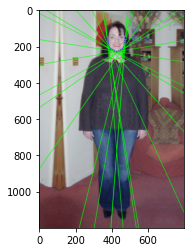

In [ ]:
def visualize(num= 4):
    img = DS[num]['imagem']
    p = DS[num]['previsao']
    ind = np.lexsort((p[:17,1],p[:17,0]))
    x,y = p[ind][:17,0],p[ind][:17,1]

    ox0 = None


    for x0,y0 in zip(x,y):
        if ox0 is not None:
            drawLine(img,x0,y0,ox0,oy0)
        cv.circle(img,(x0,y0),5,(255,0,0),-1)
        ox0,oy0 = x0,y0
    plt.imshow(img[:,:,::-1])
visualize(6)

In [ ]:
import matplotlib.pyplot as plt

def draw_lines(image,*tuples_points):
    for tuple_points in tuples_points:
        (Xa, Ya), (Xb, Yb) = tuple_points
        color = list(np.random.random(size=3) * 256)
        cv.line(image, (Xa,Ya), (Xb,Yb), color, 2)

def calc_dists(*tuples_points):
        dists = []
        for tuple_points in tuples_points:
            (Xa, Ya), (Xb, Yb) = tuple_points
            dists.append(sqrt( (Xa - Xb)**2 + (Ya - Yb)**2))
        return dists

def draw_circle(img, center, radius):
    color = list(np.random.random(size=3) * 256)
    cv.circle(img,center, radius, color, 2)
    

def sample_visualization(dataset, idx):
    image, p = dataset[idx]['imagem'], dataset[idx]['previsao']
    r = calc_dists((p[1],p[31]))[0]/2
    r2 = calc_dists((p[15],p[35]))[0]/2
    draw_lines(image,(p[31],p[35]),(p[48],p[54]),
                (p[0],p[16]),(p[2],p[14]),
                (p[4],p[12]),(p[6],p[10]))
    
    cen_x, cen_y = p[31]
    draw_circle(image,(int(cen_x - r),cen_y),int(r))

    cen_x, cen_y = p[35]
    draw_circle(image,(int(cen_x + r2),cen_y),int(r2))
    
    plt.figure(figsize=(8,12))
    plt.imshow(image[:,:,::-1])

2
2


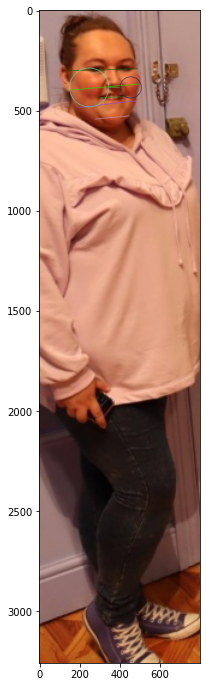

In [ ]:
sample_visualization(DS,5)

In [ ]:
import numpy as np

def PrepareInput(dataset,adjust= False): # Classification
    inputs, targets = [], []

    for idx, data in enumerate(dataset,0):
        if data['componentes'] is not None:
            inputs.append(np.array(data['componentes']))
            if data['peso']/(data['estatura']/100)**2 > 24.9:
                targets.append(1)
            else:
                targets.append(0)
        
        if idx % 100 == 99:
            print(f'[{idx + 1}/{len(dataset)}] Iterações')
    print(f'Preprocessamento Concluído [{idx + 1}/{len(dataset)}]')
    return inputs, targets

In [ ]:
input = PrepareInput(DS)

[100/933] Iterações
[200/933] Iterações
[300/933] Iterações
[400/933] Iterações
[500/933] Iterações
[600/933] Iterações
[700/933] Iterações
[800/933] Iterações
[900/933] Iterações
Preprocessamento Concluído [933/933]


In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

class Classifiers():
    def __init__(self, data, pca=True):
        self.X, self.y = data
        
        self.names = [
            "Nearest Neighbors",
            "Linear SVM",
            "RBF SVM",
            "Gaussian Process",
            "Decision Tree",
            "Random Forest",
            "Neural Net",
            "AdaBoost",
            "Naive Bayes",
            "QDA",
        ]

        self.classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1,max_iter=2000),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        ]

        self.cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

        self.model = dict()
        for name, clf in zip(self.names, self.classifiers):
            if pca:
                self.model[name] = Pipeline([('scaler',StandardScaler()),
                                            ('pca', PCA(n_components=8)),
                                            ('tree', clf)])
            else:
                self.model[name] = Pipeline([('scaler',StandardScaler()),
                                            ('tree', clf)])
            self.model[name].fit(self.X,self.y)

            n_scores = cross_val_score(self.model[name], self.X, self.y, scoring='accuracy', cv=self.cv, n_jobs=-1, error_score='raise')

            print('Classifier: %s\nAccuracy: %.3f (%.3f)' % (name, np.mean(n_scores), np.std(n_scores)))
    

In [ ]:
Classifiers(input,pca=False) #FirstMethod

* Classifier: Nearest Neighbors
** Accuracy: 0.623 (0.041)
* Classifier: Linear SVM
** Accuracy: 0.642 (0.004)
* Classifier: RBF SVM
** Accuracy: 0.697 (0.041)
* Classifier: Gaussian Process
** Accuracy: 0.695 (0.043)
* Classifier: Decision Tree
** Accuracy: 0.663 (0.036)
* Classifier: Random Forest
** Accuracy: 0.676 (0.045)
* Classifier: Neural Net
** Accuracy: 0.688 (0.041)
* Classifier: AdaBoost
** Accuracy: 0.671 (0.042)
* Classifier: Naive Bayes
** Accuracy: 0.603 (0.050)
* Classifier: QDA
** Accuracy: 0.663 (0.041)



In [ ]:
Classifiers(input) #SecondMethod

* Classifier: Nearest Neighbors
** Accuracy: 0.579 (0.042)
* Classifier: Linear SVM
** Accuracy: 0.642 (0.004)
* Classifier: RBF SVM
** Accuracy: 0.642 (0.004)
* Classifier: Gaussian Process
** Accuracy: 0.519 (0.056)
* Classifier: Decision Tree
** Accuracy: 0.610 (0.052)
* Classifier: Random Forest
** Accuracy: 0.642 (0.024)
* Classifier: Neural Net
** Accuracy: 0.621 (0.042)
* Classifier: AdaBoost
** Accuracy: 0.628 (0.039)
* Classifier: Naive Bayes
** Accuracy: 0.647 (0.043)
* Classifier: QDA
** Accuracy: 0.605 (0.061)

# Optimal threshold

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
input_df = pd.DataFrame(input).transpose()

In [ ]:
train, val = input_df[:int(len(input_df)*0.8)], input_df[int(len(input_df)*0.8):]

In [ ]:
pos_weights = (len(train[1]) - sum(train[1])) / (sum(train[1])) 

pipeline_tf = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=100, class_weight={0: 1, 1: pos_weights}))
])

In [ ]:
pipeline_tf.fit([[i] for i in train[0]], train[1].values.astype(float))

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(class_weight={0: 1,
                                                      1: 0.5738095238095238},
                                        random_state=100))])

In [ ]:
predictions = pipeline_tf.predict([[i] for i in val[0]])

In [ ]:
predicted_proba = pipeline_tf.predict_proba([[i] for i in val[0]])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
print("Accuracy Score Before Thresholding: {}".format(accuracy_score(val[1].values.astype(float), predictions)))
print("Precision Score Before Thresholding: {}".format(precision_score(val[1].values.astype(float), predictions)))
print("Recall Score Before Thresholding: {}".format(recall_score(val[1].values.astype(float), predictions)))
print("F1 Score Before Thresholding: {}".format(f1_score(val[1].values.astype(float), predictions)))
print("ROC AUC Score: {}".format(roc_auc_score(val[1].values.astype(float), predicted_proba[:, -1])))

Accuracy Score Before Thresholding: 0.5662650602409639
Precision Score Before Thresholding: 0.6788990825688074
Recall Score Before Thresholding: 0.6666666666666666
F1 Score Before Thresholding: 0.6727272727272727
ROC AUC Score: 0.5151515151515151
